In [1]:
%load_ext snakeviz

In [1]:
from typing import Iterable
from nilearn import plotting
from nilearn import datasets

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

In [2]:
import nibabel as nib
import numpy as np

In [3]:
from neurolang import frontend as fe

from nilearn.datasets import utils
import pandas as pd

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/tatsu/grammars.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import defaultdict, Mapping


# Prepare NeuroSynth 

In [4]:
d_neurosynth = utils._get_dataset_dir('neurosynth', data_dir='neurolang_data')

f_neurosynth = utils._fetch_files(
    d_neurosynth, [
        (
            f,
            'https://github.com/neurosynth/neurosynth-data/raw/master/current_data.tar.gz',
            {'uncompress': True}
        )
        for f in ('database.txt', 'features.txt')
    ],
    verbose=True
)

database = pd.read_csv(f_neurosynth[0], sep='\t')
features = pd.read_csv(f_neurosynth[1], sep='\t')

features_normalised = (
    features
    .melt(id_vars=features.columns[0], var_name='term', value_vars=features.columns[1:], value_name='tfidf')
    .query('tfidf > 0')
)



In [5]:
nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table
vox_ids, study_ids_ix = it.data.nonzero()
study_ids = ns_ds.image_table.ids[study_ids_ix]
study_id_vox_id = np.transpose([study_ids, vox_ids])
masked_ = it.masker.unmask(np.arange(it.data.shape[0]))
nnz = masked_.nonzero()
vox_id_MNI = np.c_[
    masked_[nnz].astype(int),
    nib.affines.apply_affine(it.masker.volume.affine, np.transpose(nnz)),
    [
        fe.ExplicitVBR(
            [v],
            affine_matrix=it.masker.volume.affine,
            image_dim=it.masker.volume.shape
        )
        for v in zip(*nnz)
    ]
]

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()


In [6]:
from nilearn import image
dd = datasets.fetch_atlas_destrieux_2009()
destrieux_to_ns_mni = image.resample_to_img(dd['maps'], it.masker.volume, interpolation='nearest')
dd_data = destrieux_to_ns_mni.get_fdata()
dd_unmaskes = np.where(destrieux_to_ns_mni.get_fdata() > 0)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [7]:
xyz_to_dd_region = []
for v in zip(*dd_unmaskes):
    region = dd_data[v[0]][v[1]][v[2]]
    xyz_to_dd_region.append((v, region))

In [8]:
dd_labels = []
for n, name in dd['labels']:
    dd_labels.append((n, name.decode('UTF-8')))

In [9]:
xyz_to_ns_region = []
for n, _, _, _, region in vox_id_MNI:
    xyz_to_ns_region.append((tuple(region.voxels[0]), n))   

# Initialise and load the fronte-end

In [10]:
nl = fe.NeurolangDL()

@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

ns_pmid_term_tfidf = nl.add_tuple_set(features_normalised.values, name='ns_pmid_term_tfidf')
ns_activations = nl.add_tuple_set(database[['id', 'x', 'y', 'z', 'space']].values, name='ns_activations')
ns_activations_by_id = nl.add_tuple_set(
    study_id_vox_id, name='ns_activations_by_id'
)
ns_vox_id_MNI = nl.add_tuple_set(vox_id_MNI, name='ns_vox_id_MNI')

xyz_ns = nl.add_tuple_set(xyz_to_ns_region, name='xyz_ns')
xyz_dd = nl.add_tuple_set(xyz_to_dd_region, name='xyz_dd')
dd_label = nl.add_tuple_set(dd_labels, name='dd_label')

In [25]:
term = 'auditory'
studies_term = nsh.ns_study_tfidf_feature_for_terms(terms=term)
df = pd.DataFrame(studies_term, columns=["study", "term", 'prob'])
df = df.astype({"study": int})
df[["study", "term", "prob"]]

,study,term,prob


## Test Destrieux restriction

In [11]:
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.term == 'auditory') &
        (e.tfidf > 1e-3)        
    )
    
    e.dd_to_ns[e.dd_name, e.ns_id, e.xyz2] = (
        xyz_dd[e.xyz1, e.dd_name] &
        xyz_ns[e.xyz2, e.ns_id] &
        (e.xyz1 == e.xyz2)
    )
    
    e.act_term_counts[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid]
    )
    
    e.act_term_counts_limited[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid] &
        e.dd_to_ns[e.dd_id, e.voxid, e.xyz] &
        dd_label[e.dd_id, 'L G_precentral']
    )
    
    res = nl.solve_all()
    assert len(res['act_term_counts'].unwrap()) > len(res['act_term_counts_limited'].unwrap())

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


## Forward inference on term "Auditory" with restriction using Destrieux

In [12]:
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.term == 'auditory') &
        (e.tfidf > 1e-3)        
    )
    
    e.dd_to_ns[e.dd_name, e.ns_id, e.xyz2] = (
        xyz_dd[e.xyz1, e.dd_name] &
        xyz_ns[e.xyz2, e.ns_id] &
        (e.xyz1 == e.xyz2)
    )

    e.act_term_counts[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid] &
        e.dd_to_ns[e.dd_id, e.voxid, e.xyz] &
        dd_label[e.dd_id, 'R S_temporal_sup']
    )
    
    e.act_term_counts[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid] &
        e.dd_to_ns[e.dd_id, e.voxid, e.xyz] &
        dd_label[e.dd_id, 'L S_temporal_sup']
    ) 

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
 
    e.p_act_given_term[e.voxid, e.x, e.y, e.z, e.term, e.prob] = (
        e.act_term_counts[e.term, e.voxid, e.act_term_count] &
        e.term_counts[e.term, e.term_count] &
        e.ns_vox_id_MNI[e.voxid, e.x, e.y, e.z] &
        (e.prob == (e.act_term_count / e.term_count))
    )
    res = nl.solve_all()

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


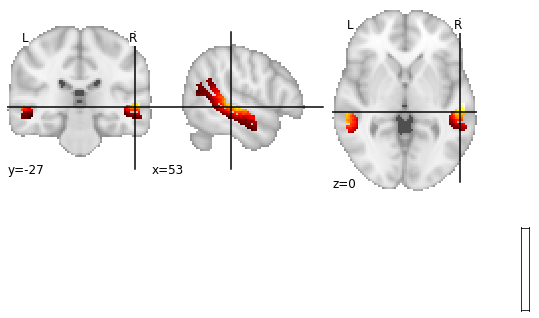

In [13]:
mni_t1 = it.masker.volume

ijk_coords = tuple(
    (
        np.round(
            nib.affines.apply_affine(
                np.linalg.inv(mni_t1.affine),
                res['p_act_given_term'].unwrap().as_numpy_array()[:, 1:4]
            ).astype(float).T
        ).T
    ).astype(int).T
)

res_img = np.zeros(mni_t1.shape)
res_img[ijk_coords] = res['p_act_given_term'].unwrap().as_numpy_array()[:, -1]

res_sp = nib.spatialimages.SpatialImage(
    dataobj=res_img, affine=mni_t1.affine
)

plotting.plot_stat_map(res_sp)

## Forward inference on term "Auditory"

In [11]:
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.term == 'auditory') &
        (e.tfidf > 1e-3)        
    )

    e.act_term_counts[e.term, e.voxid, agg_count(e.pmid)] = (
        ns_activations_by_id[e.pmid, e.voxid] &
        e.term_docs[e.term, e.pmid]
    )    

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
 
    e.p_act_given_term[e.voxid, e.x, e.y, e.z, e.term, e.prob] = (
        e.act_term_counts[e.term, e.voxid, e.act_term_count] &
        e.term_counts[e.term, e.term_count] &
        e.ns_vox_id_MNI[e.voxid, e.x, e.y, e.z] &
        (e.prob == (e.act_term_count / e.term_count))
    )
    res = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


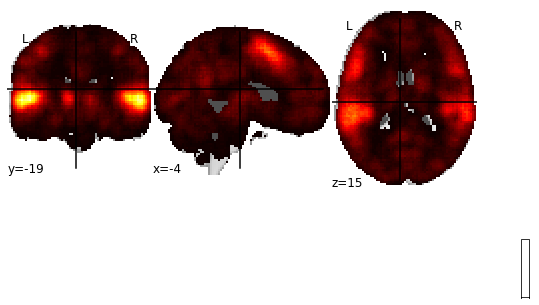

In [12]:
mni_t1 = it.masker.volume

ijk_coords = tuple(
    (
        np.round(
            nib.affines.apply_affine(
                np.linalg.inv(mni_t1.affine),
                res['p_act_given_term'].unwrap().as_numpy_array()[:, 1:4]
            ).astype(float).T
        ).T
    ).astype(int).T
)

res_img = np.zeros(mni_t1.shape)
res_img[ijk_coords] = res['p_act_given_term'].unwrap().as_numpy_array()[:, -1]

res_sp = nib.spatialimages.SpatialImage(
    dataobj=res_img, affine=mni_t1.affine
)

plotting.plot_stat_map(res_sp)

## Reverse Inference Terms Associated with Voxels Associated with "Auditory"

In [13]:
r = res['p_act_given_term'].unwrap()
thresh_voxels = r.selection(lambda x: x[5] > .12)

In [14]:
auditory_voxels_prob = nl.add_tuple_set(thresh_voxels.as_numpy_array(), name='auditory_voxels_prob');

In [ ]:
with nl.scope as e:
    e.term_docs[e.term, e.pmid] = (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    e.act_counts[e.voxid, agg_count(e.pmid)] = ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        auditory_voxels_prob[e.voxid, e.x, e.y, e.z, e.term_, e.prob_] &
        e.term_docs[e.term, e.pmid] &
        ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        e.act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        e.act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    res = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [19]:
res['e_term_given_aud_act']

                   0         1
0                001  0.000711
1                 01  0.001320
2                 05  0.001964
3                 10  0.007932
4                100  0.001416
...              ...       ...
3223     young older  0.000663
3224         younger  0.002395
3225  younger adults  0.001172
3226           youth  0.000407
3227            zone  0.000758

[3228 rows x 2 columns]

In [20]:
c = res['e_term_given_aud_act']._container.copy()

### Keep the terms that are on the top 1%

In [ ]:
c[1].hist();

In [ ]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

In [96]:
atlas_l_filename = './22/MPM/JulichBrain_MPMAtlas_l_N10_nlin2Stdicbm152asym2009c_publicDOI_3f6407380a69007a54f5e13f3c1ba2e6.nii.gz'
atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'

img_l = image.load_img(atlas_l_filename)
img_l = image.resample_img(img_l, it.masker.volume.affine)

julich_to_ns_mni = image.resample_to_img(
    img_l, it.masker.volume, interpolation="nearest"
)

jl_data = julich_to_ns_mni.get_fdata()
jl_unmaskes = np.nonzero(julich_to_ns_mni.get_fdata())

xyz_to_jl_region = []
for v in zip(*jl_unmaskes):
    region = jl_data[v[0]][v[1]][v[2]]
    coord = nib.affines.apply_affine(img_l.affine, list(v))
    xyz_to_jl_region.append((tuple(coord), region))

xyz_jl = nl.add_tuple_set(
    xyz_to_jl_region,
    name="xyz_julich",
)

In [107]:
img_l = image.load_img(atlas_r_filename)

#image.resample_img(img_l, it.masker.volume.affine)

In [110]:
img_l.affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


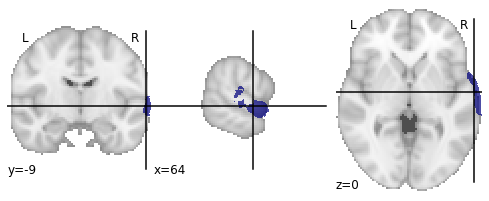

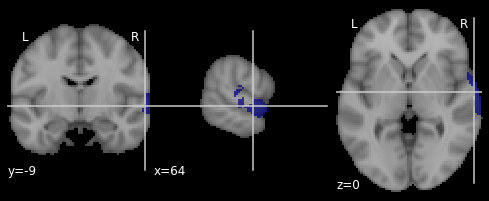

In [119]:
import nibabel as nib
from nilearn import plotting
import nilearn
mpm = nib.load('./22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz')
new_data = mpm.get_fdata()
new_data[new_data != 30] = 0
mpm_31 = nib.spatialimages.SpatialImage(new_data, affine=mpm.affine)
plotting.plot_roi(mpm_31)
ns = nib.load('/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/resources/MNI152_T1_2mm_brain.nii.gz')
mpm_31_2 = nilearn.image.resample_to_img(mpm_31, ns, interpolation='nearest')
plotting.plot_roi(mpm_31_2, bg_img=ns)

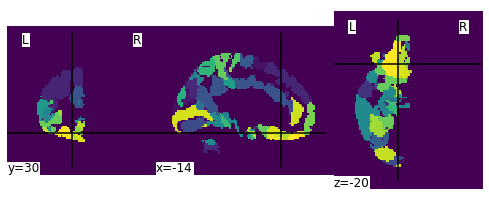

In [99]:
plotting.plot_img(
    img_l,
    #title='Tag "auditory" (Neurolang)', 

)

In [120]:
it.masker.volume

In [89]:
xyz_to_jl_region

[((64.0, -30.0, 20.0), 31.0),
 ((64.0, -30.0, 22.0), 31.0),
 ((64.0, -30.0, 24.0), 31.0),
 ((64.0, -28.0, 18.0), 31.0),
 ((64.0, -28.0, 20.0), 31.0),
 ((64.0, -28.0, 22.0), 31.0),
 ((64.0, -28.0, 24.0), 31.0),
 ((64.0, -26.0, 16.0), 31.0),
 ((64.0, -26.0, 18.0), 31.0),
 ((64.0, -26.0, 20.0), 31.0),
 ((64.0, -26.0, 22.0), 31.0),
 ((62.0, -32.0, 22.0), 31.0),
 ((62.0, -30.0, 18.0), 31.0),
 ((62.0, -30.0, 20.0), 31.0),
 ((62.0, -30.0, 22.0), 31.0),
 ((62.0, -30.0, 24.0), 31.0),
 ((62.0, -30.0, 26.0), 31.0),
 ((62.0, -28.0, 16.0), 31.0),
 ((62.0, -28.0, 18.0), 31.0),
 ((62.0, -28.0, 20.0), 31.0),
 ((62.0, -28.0, 22.0), 31.0),
 ((62.0, -28.0, 24.0), 31.0),
 ((62.0, -28.0, 26.0), 31.0),
 ((62.0, -28.0, 34.0), 31.0),
 ((62.0, -28.0, 36.0), 31.0),
 ((62.0, -26.0, 18.0), 31.0),
 ((62.0, -26.0, 20.0), 31.0),
 ((62.0, -26.0, 22.0), 31.0),
 ((62.0, -26.0, 24.0), 31.0),
 ((62.0, -26.0, 26.0), 31.0),
 ((62.0, -26.0, 28.0), 31.0),
 ((62.0, -26.0, 34.0), 31.0),
 ((62.0, -26.0, 36.0), 31.0),
 ((62.0, -

In [48]:
it.masker.volume.affine

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [73]:
jl = zip(*jl_unmaskes)

In [76]:
img_l = nib.affines.apply_affine(it.masker.volume.affine, list(zip(*jl_unmaskes)))

In [78]:
img_l

array([[ 72., -36.,  -2.],
       [ 72., -34.,  -4.],
       [ 72., -34.,  -2.],
       ...,
       [ -6., -40.,  54.],
       [ -6., -34.,  50.],
       [ -6., -26.,  60.]])

In [79]:
julich_to_ns_mni = image.resample_to_img(
    img_l, it.masker.volume, interpolation="nearest"
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/_utils/niimg.py:150: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(niimgs, collections.Iterable):


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
72.0

In [3]:
from nilearn import image
import nibabel as nib
from neurolang import frontend as fe

nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table


atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'
    
img_l = image.load_img(atlas_r_filename)

ns = nib.load('/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/resources/MNI152_T1_2mm_brain.nii.gz')
julich_to_ns_mni = image.resample_to_img(
    img_l, it.masker.volume, interpolation="nearest"
)
    

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()


In [19]:
orientation_julich = nib.orientations.axcodes2ornt(nib.orientations.aff2axcodes(img_l.affine))
orientation_ns = nib.orientations.axcodes2ornt(nib.orientations.aff2axcodes(it.masker.volume.affine))

In [38]:
import numpy as np

In [50]:
ornt_transform = nib.orientations.ornt_transform(orientation_julich, orientation_ns)
ornt_transform_affine = nib.orientations.inv_ornt_aff(ornt_transform, img_l.shape)
ornt_transform_affine

array([[ -1.,   0.,   0., 192.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [58]:
orientation_affine = np.dot(
    img_l.affine,
    ornt_transform_affine
)
img_l_LAS = nib.spatialimages.SpatialImage(
    nib.orientations.apply_orientation(img_l.dataobj, ornt_transform),
    orientation_affine
)

In [66]:
img_l_ns = image.resample_to_img(img_l, it.masker.volume)
img_l_ns.affine

array([[  -2.,    0.,    0.,   90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])

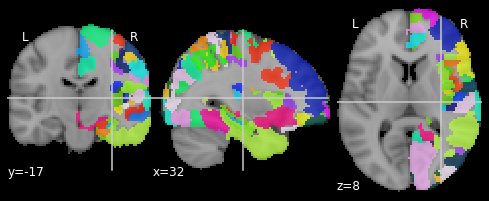

In [67]:
plotting.plot_roi(img_l_ns, bg_img=it.masker.volume)

In [31]:
from nilearn import plotting

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)


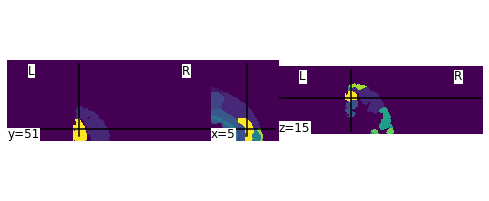

In [32]:
plotting.plot_img(img_l_mni_ornt)

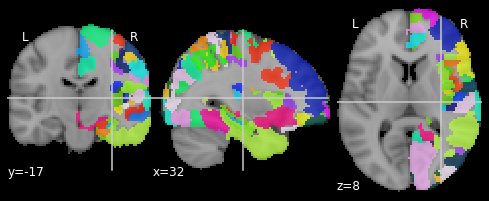

In [68]:
atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'
img_r = image.load_img(atlas_r_filename)
julich_to_ns_mni = image.resample_to_img(
    img_r, it.masker.volume, interpolation="nearest"
)
plotting.plot_roi(julich_to_ns_mni, bg_img=it.masker.volume)